# Trigrams
title = "Trigrams"
date = "2024-12-04T10:26:20+13:00"
author = ""
authorTwitter = "" #do not include @
cover = ""
description = ""
showFullContent = false
readingTime = false
hideComments = false
color = "" #color from the theme settings
<!--eofm-->

# Monthly Algorithmic Challenge (November 2024): Trigrams

Last week, I worked through the monthly Mechanistic Interpretability challenge from [Callum McDougall's ARENA course](https://arena3-chapter1-transformer-interp.streamlit.app/Monthly_Algorithmic_Problems).

*(A huge shoutout to Callum and the entire ARENA team for all the work they do!)*

The challenge was to interpret how a simple neural net - in this case, a 1 layer 1 head transformer (with MLP) - solves a problem.
The problem at hand was to predict the next token in a sequence of random tokens. As the model was trained with cross-entropy
loss, training on a completely random dataset would lead the model to always uniformly predict all tokens in the vocabulary.

*However*, inserted randomly throughout the dataset were **trigrams**, sequences of 3 tokens which always followed the pattern

`trigram[0], trigram[1]` => `trigram[2].`

For example, for a trigram `(1, 2, 3)` and the sequence `5 74 38 12 52 1 2`, we know for certain the next token is `3`.

Consequently, we expect the model to develop ways of detecting the presence of trigrams, determining *which* trigram is present, retrieving the correct completion, and writing to the output to confidently predict the correct completion token. The mechanisms the model learns to do this are explored below.

My work starts from ["Misc Tools"](#Misc-Tools) onwards.

If you're comfortable with Jupyter Notebooks/Google Colab, I'd recommend reading through the 
interactive version of this page, linked as a Google Colab notebook, [here.](https://colab.research.google.com/drive/161EE2W98h_mpphESWv_mPtbv__MZP8jV?usp=sharing)

# Beginning of Attempt

# Misc Tools

In [7]:
def get_trigram_positions(dataset: BigramDataset) -> Tuple[
Float[Tensor, "n_trigram_occurences"], Float[Tensor, "n_trigram_occurences"]]:
    """Return the batch and sequence positions of trigrams
    for the tokens in a dataset."""
    # Do a 2-wide sliding window
    pairs = dataset.toks.unfold(dimension=1, size=2, step=1)
    patterns = t.tensor([[trigram[0], trigram[1]] for trigram in dataset.trigrams], device=device)

    # Match all pairs against all patterns.
    # 'matches' gives the position where a particular trigram matches.
    matches = (pairs.unsqueeze(2) == patterns.reshape(1, 1, len(patterns), 2)).all(dim=-1) # [batch, seq - 1, num_patterns]

    # trigram_pos gives the starting position of *any* valid trigram.
    batch_idx, seq_idx = t.where(matches.any(dim=-1))

    return batch_idx, seq_idx

# Attention Patterns

The first thing to probe is the attention head. To figure out what algorithm/s it might be implementing, we want to plot a number of different batches against the attention patterns.

In particular, we add two markers to the plot:

1. A ✓ to indicate the model made a correct prediction of the next token,
based on this sequence position.
2. A highlighted horizontal bar, indicating the presence of the first two elements (trigram[0] and trigram[1]) of a trigram.

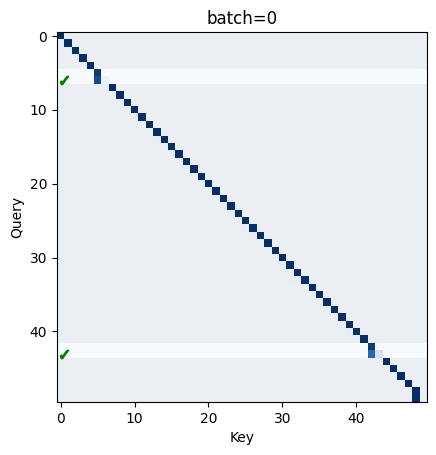

In [33]:
batch_idx, seq_idx = get_trigram_positions(dataset)

def visualize_attn(batch=0):
    trigrams = seq_idx[batch_idx == batch]
    attn = cache['blocks.0.attn.hook_pattern'][batch, 0] # select batch, head = 0 -> [q_seq, k_seq]

    bound = max(attn.min().abs(), attn.max().abs())
    plt.title(f"{batch=}")
    plt.imshow(attn.cpu(), vmin=0, vmax=bound, cmap='Blues')
    plt.xlabel("Key")
    plt.ylabel("Query")

    # Visualize if the model makes a correct prediction
    correct_predictions = t.where(logits[batch, :-1].argmax(dim=1) == dataset.toks[batch, 1:])[0]
    plt.plot([0.5] * len(correct_predictions), correct_predictions.cpu(), "g", linestyle='', marker="$✓$")
    # Highlight places where trigrams are present (in the query direction).
    mask = t.zeros_like(attn, device=device)
    mask[trigrams] = 1
    mask[trigrams + 1] = 1


    plt.imshow(mask.cpu(), alpha=0.05, cmap='gray')
    plt.show()


# interact(visualize_attn, batch=(0, logits.shape[0] - 1, 1))
visualize_attn(batch=0)

From the plot, we can see a few interesting things:

- Firstly, by default the head attends to the current sequence position. We can probably think of this as a 'no-op'.

- Secondly, most of the time when a trigram is present, the query key for `trigram[1]` will attend strongly (>0.9) to `trigram[0]`. Less frequently, the head will split attention between `trigram[1]` and `trigram[0]` roughly evenly, and ignore everything else.

- Thirdly, for some trigrams, the model makes a correct prediction of `trigram[2]` but only attends to `trigram[1]`.

- Finally, the model occasionally makes correct predictions when no trigrams are present, which is just the result of a lucky guess.

Point one makes sense: the model doesn't need to know anything about the previous token if it is just going to make a guess (in the case of no trigram).
Point two also makes some sense: the residual stream for `trigram[1]` always contains information about `trigram[1]`. For the unembeddings or the MLP later on to make a correct guess, however, the residual stream also needs some information about `trigram[0]`, and the only way it can get this is by attending to the previous token.

What's perhaps counter-intuitive is that sometimes the model makes correct predictions in the presence of a trigram without attending to `trigram[0]` at all!

To get a better understanding of what's going on, let's break apart the attention mechanism into position-based and token-based - that is, projecting the `W_pos` and `W_E` matrices into the attention space.

Below, we plot these two components for the tokens in each batch, all pre-softmax.

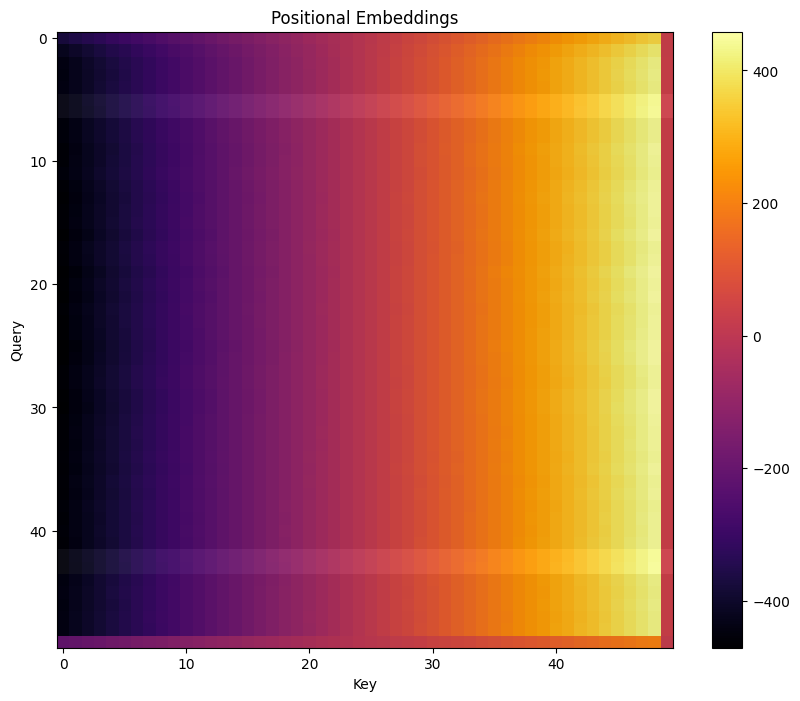

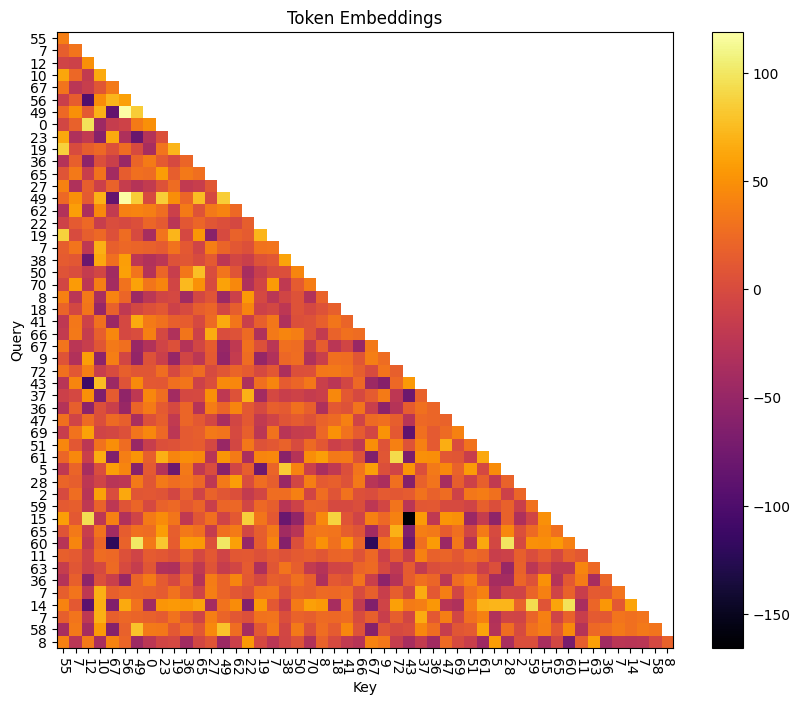

In [34]:
def mask_trigrams(attn, batch=0):
    """Show a highlighted area over the query-sequence
    positions where `trigram[0], trigram[1]` are
    present. """
    trigrams = seq_idx[batch_idx == batch]
    mask = t.zeros_like(attn[batch], device=device)
    mask[trigrams] = 1
    mask[trigrams + 1] = 1
    plt.imshow(mask.cpu(), alpha=0.05, cmap='gray')

batch = 0

def plot_tok_pos(batch):
  """Plot the attention head contributions from token embeddings
  and positional embeddings, separately."""
  # Positional embedding only
  q_pos = (cache['pos_embed']) @ model.W_Q[0, 0] + model.b_Q[0, 0]
  k_pos = (cache['pos_embed']) @ model.W_K[0, 0] + model.b_K[0, 0]
  attn_pos = einops.einsum(q_pos, k_pos, "... qseq dhead, ... kseq dhead -> ... qseq kseq")#.masked_fill_(t.triu(t.ones(q_pos.shape[-2], q_pos.shape[-2]).bool(), diagonal=1), -t.inf)

  fig, ax = plt.subplots(figsize=(10, 8))
  plt.title("Positional Embeddings")
  f = ax.imshow(attn_pos[0].cpu(), cmap="inferno")
  plt.colorbar(f)
  mask_trigrams(attn_pos, batch)
  ax.set_ylabel("Query")
  ax.set_xlabel("Key")
  plt.show()

  # Token only, no positional embeddings
  q_tok = (cache['hook_embed']) @ model.W_Q[0, 0] + model.b_Q[0, 0]
  k_tok = (cache['hook_embed']) @ model.W_K[0, 0] + model.b_K[0, 0]
  attn_tok = einops.einsum(q_tok, k_tok, "... qseq dhead, ... kseq dhead -> ... qseq kseq").masked_fill_(t.triu(t.ones(q_tok.shape[-2], q_tok.shape[-2], device=device).bool(), diagonal=1), -t.inf)


  fig, ax = plt.subplots(figsize=(10, 8))
  plt.title("Token Embeddings")
  f = ax.imshow(attn_tok[batch].cpu(), cmap="inferno")
  plt.colorbar(f)
  ax.set_xticks(np.arange(dataset.toks.shape[1]), dataset.toks[batch].cpu().numpy(), rotation=-90)
  ax.set_yticks(np.arange(dataset.toks.shape[1]), dataset.toks[batch].cpu().numpy())
  ax.set_ylabel("Query")
  ax.set_xlabel("Key")
  plt.show()

# interact(plot_tok_pos, batch=(0, logits.shape[0] - 1, 1))
plot_tok_pos(batch=0)

# Initial Hypothesis
## Token Embeddings
The query vector is looking for a token that precedes it in a trigram.

E.g. for token 47, the query vector is looking for 2, 4, or 41 (because (2, 47, 28), (4, 47, 23), and (41, 47, 3) are all valid trigrams.)

The key vector indicates which token it represents. For token 41, the key vector says "I am 41".

## Positional Embeddings
The positional embeddings are monotonic and essentially linear based on sequence position, with higher scores for later tokens. This means that the highest attention score is, by default, always the current token.

The positional embeddings for the last position of the sequence appears to be nonsense, because there is no correct prediction to learn.

## Combined Embeddings
Combining the two embeddings, the algorithm for detecting trigrams appears to be:

    1. Use token embeddings to determine if a preceding token matches the current token. That is, increase attention when (key == trigram[0]) and (query == trigram[1]).

    2. Use positional embeddings to mask out the attention scores for all keys except the immediately previous one.

This *could* explain how the model works for almost all trigrams.

The one notable exception to this are for trigrams with repeats, e.g. (72, 72, 48). In this case, the model appears to attend only to the most recent occurence of the token. Given what we suspect about how this model's attention mechanism works, we shouldn't really expect it to do anything else.

- The monotonic nature of the learned positional embeddings mean the most recent token always gets precedence
- The token embeddings for two identical keys must, by definition, be identical
- Because softmax is translation invariant, the model can't just make the token-based attention score very high in the case of duplicated sequences, because only the difference between the two positions' attention scores matters.

How, then, does the model predict these duplicate trigrams (and it does predict them correctly!)

Maybe the MLP directly implements predictions for repeated tokens? However, there's no mechanism for the MLP to get information about the previous token without an attention head playing ball and telling it the current token is a repeat. Since the positional embedding scheme in the single head present doesn't do that, there's really only one avenue left for the model to predict completions of duplicate-starting trigrams: fake it!

Since `trigram[0], trigram[1]` always imply the same `trigram[2]`, the model can always guess the correct completion, regardless of whether the current token is a duplicate.

Is this what we see?

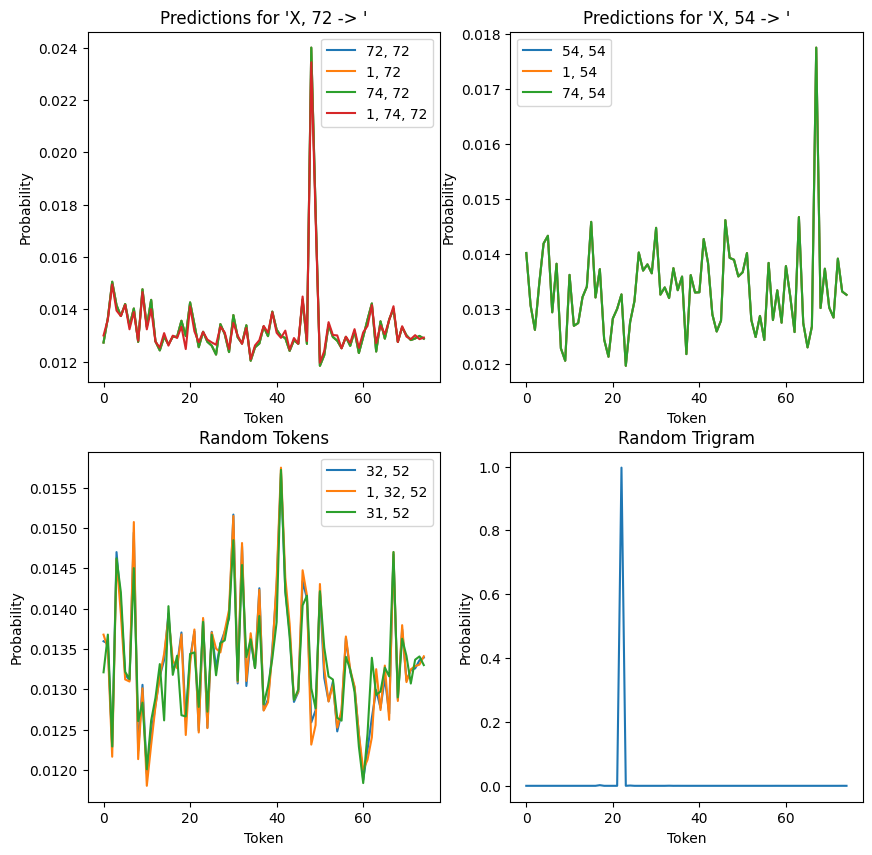

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))


axes[0][0].set_title("Predictions for 'X, 72 -> '")
axes[0][0].plot(model(t.tensor([[72, 72]]))[0, -1].softmax(dim=-1).cpu(), label="72, 72")
axes[0][0].plot(model(t.tensor([[1, 72]]))[0, -1].softmax(dim=-1).cpu(), label="1, 72")
axes[0][0].plot(model(t.tensor([[74, 72]]))[0, -1].softmax(dim=-1).cpu(), label="74, 72")
axes[0][0].plot(model(t.tensor([[1, 74, 72]]))[0, -1].softmax(dim=-1).cpu(), label="1, 74, 72")
axes[0][0].set_xlabel("Token")
axes[0][0].set_ylabel("Probability")
axes[0][0].legend()

# a series of random tokens (of the same sequence length)
# that end in 54
axes[0][1].set_title("Predictions for 'X, 54 -> '")
axes[0][1].plot(model(t.tensor([[54, 54]]))[0, -1].softmax(dim=-1).cpu(), label="54, 54")
axes[0][1].plot(model(t.tensor([[1, 54]]))[0, -1].softmax(dim=-1).cpu(), label="1, 54")
axes[0][1].plot(model(t.tensor([[74, 54]]))[0, -1].softmax(dim=-1).cpu(), label="74, 54")
axes[0][1].set_xlabel("Token")
axes[0][1].set_ylabel("Probability")
axes[0][1].legend()

# two random tokens that are not a trigram
axes[1][0].set_title("Random Tokens")
axes[1][0].plot(model(t.tensor([[32, 52]]))[0, -1].softmax(dim=-1).cpu(), label="32, 52")
axes[1][0].plot(model(t.tensor([[1, 32, 52]]))[0, -1].softmax(dim=-1).cpu(), label="1, 32, 52")
axes[1][0].plot(model(t.tensor([[31, 52]]))[0, -1].softmax(dim=-1).cpu(), label="31, 52")
axes[1][0].legend()
axes[1][0].set_xlabel("Token")
axes[1][0].set_ylabel("Probability")

# two random tokens that **are** a trigram
axes[1][1].set_title("Random Trigram")
axes[1][1].plot(model(t.tensor([[26, 49]]))[0, -1].softmax(dim=-1).cpu())
axes[1][1].set_xlabel("Token")
axes[1][1].set_ylabel("Probability")


plt.show()

Above, we have four plots showing (from top left, clockwise):

1. For any sequence (that isn't a non-repeating trigram) ending in 72, the model always makes the same prediction. That is, it (weakly) predicts the correct continuation of the (72, 72, 48) trigram.
2. For another repeating trigram (54, 54, 67), we have the same behaviour: all sequences ending in 54 weakly predict 67 as the follow up.
3. Picking an arbitrary non-repeating trigram (in this case, (26, 49, 22)), we see that the model very strongly predicts the correct continuation (22). This is quite different to the two preceding plots, where the prediction was closer to uniform.
4. If we look at a number of non-trigram sequences, we can see that while predictions are fairly uniform, both sequence position and the preceding token appear to slightly tweak the exact distribution output. This is markedly different to the repeating trigrams (figures 1 and 2), which vary their predictions only based on sequence position and *not* on the preceding token.

# Does Token Attention Encode Trigram Starts?

If the model is really using key-query vectors to encode `trigram[0], trigram[1]` pairs, we should be able to see that directly. Looking at the first 50 sequence positions:

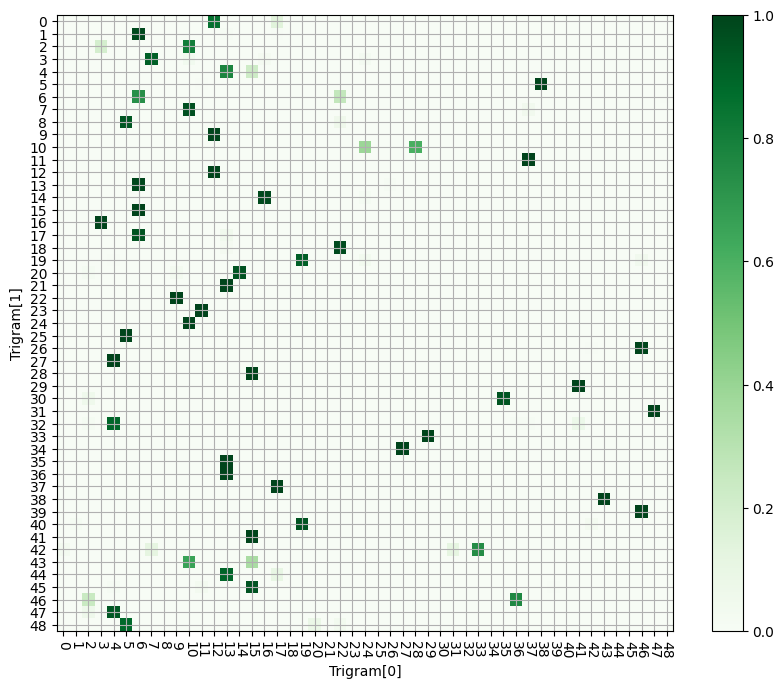

In [11]:
tokens = t.arange(0, model.cfg.n_ctx - 1).unsqueeze(0)
m, c = model.run_with_cache(tokens)

# Token only, no positional embeddings
q_tok = (c['hook_embed']) @ model.W_Q[0, 0] + model.b_Q[0, 0]
k_tok = (c['hook_embed']) @ model.W_K[0, 0] + model.b_K[0, 0]
attn_tok = einops.einsum(q_tok, k_tok, "... qseq dhead, ... kseq dhead -> ... qseq kseq")

fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()
f = ax.imshow(attn_tok[0].softmax(dim=-1).cpu(), cmap='Greens')
plt.colorbar(f)
plt.xlabel("Trigram[0]")
plt.ylabel("Trigram[1]")
ax.set_xticks(np.arange(dataset.toks.shape[1] - 1), tokens[0].numpy(), rotation=-90)
ax.set_yticks(np.arange(dataset.toks.shape[1] - 1), tokens[0].numpy())
plt.show()

Indeed, we can read off the values of our trigram-starting pairs by:

    1. Pick a value from the y-axis. This is the query token, and
    represents `trigram[1]`.
    2. Read from left to right, until we encounter a large value.
    3. From this highlighted square, read off the x-axis value. This is the key value that the query was looking for - i.e. `trigram[0]`.

We can compare the hotspots on this chart to the set of possible trigrams, sorted by second element (`trigram[1]`). This gives quite good agreement, once we filter out very low values.

What's interesting is the significant variability in how intensely the model attends to different trigram pairs. It's possible this is a limitation of the space the model has to work with, or something else entirely.

In [12]:
table = Table("First Element")
table.add_column("Second Element")
table.add_column("Third Element")

for trigram in sorted(dataset.trigrams, key=lambda x: x[1]):
    table.add_row(str(trigram[0]), str(trigram[1]), str(trigram[2]))


console = Console()
console.print(table)

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ First Element ┃ Second Element ┃ Third Element ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 17            │ 0              │ 43            │
│ 57            │ 0              │ 34            │
│ 9             │ 0              │ 37            │
│ 12            │ 0              │ 20            │
│ 13            │ 1              │ 22            │
│ 6             │ 1              │ 54            │
│ 17            │ 1              │ 12            │
│ 64            │ 1              │ 8             │
│ 10            │ 2              │ 67            │
│ 56            │ 2              │ 22            │
│ 3             │ 2              │ 62            │
│ 63            │ 2              │ 17            │
│ 58            │ 3              │ 70            │
│ 15            │ 4              │ 50            │
│ 57            │ 4              │ 73            │
│ 54            │ 4              │ 4             │
│ 71            │ 4              │ 7             │
│ 13            │ 4              │ 8             │
│ 11            │ 5              │ 53            │
│ 2             │ 5              │ 17            │
│ 16            │ 5              │ 60            │
│ 38            │ 5              │ 35            │
│ 67            │ 6              │ 72            │
│ 10            │ 7              │ 56            │
│ 37            │ 7              │ 51            │
│ 52            │ 8              │ 30            │
│ 63            │ 8              │ 8             │
│ 5             │ 8              │ 0             │
│ 22            │ 8              │ 38            │
│ 12            │ 9              │ 26            │
│ 11            │ 9              │ 30            │
│ 2             │ 9              │ 59            │
│ 45            │ 10             │ 47            │
│ 4             │ 10             │ 3             │
│ 24            │ 10             │ 22            │
│ 51            │ 10             │ 65            │
│ 28            │ 10             │ 6             │
│ 37            │ 11             │ 66            │
│ 64            │ 12             │ 34            │
│ 12            │ 12             │ 4             │
│ 39            │ 12             │ 73            │
│ 6             │ 13             │ 39            │
│ 71            │ 13             │ 62            │
│ 42            │ 13             │ 69            │
│ 59            │ 13             │ 73            │
│ 47            │ 13             │ 18            │
│ 26            │ 13             │ 46            │
│ 14            │ 13             │ 9             │
│ 59            │ 14             │ 68            │
│ 9             │ 14             │ 65            │
│ 16            │ 14             │ 5             │
│ 60            │ 14             │ 16            │
│ 24            │ 14             │ 62            │
│ 22            │ 15             │ 20            │
│ 6             │ 15             │ 47            │
│ 12            │ 15             │ 54            │
│ 24            │ 15             │ 66            │
│ 71            │ 15             │ 38            │
│ 18            │ 15             │ 0             │
│ 50            │ 16             │ 16            │
│ 3             │ 16             │ 71            │
│ 6             │ 17             │ 40            │
│ 0             │ 17             │ 26            │
│ 13            │ 17             │ 16            │
│ 70            │ 17             │ 52            │
│ 57            │ 18             │ 2             │
│ 52            │ 18             │ 48            │
│ 72            │ 19             │ 18            │
│ 55            │ 19             │ 0             │
│ 60            │ 19             │ 15            │
│ 9             │ 20             │ 2             │
│ 14            │ 20             │ 1             │
│ 60            │ 20             │ 30            │
│ 2             │ 20             │ 57            │
│ 13            │ 21             │ 46            │
│ 67            │ 21  

# Testing our working model

So far, we have a strong working theory for how the model might work.

1. Use the attention mechanism to encode `(trigram[0], trigram[1])` pairs. So long as `trigram[0]` and `trigram[1]` are different numbers, the model has two modes of operation. If a trigram is detected, the attention mechanism will move some information about `trigram[0]` (via the OV-circuit) into the residual stream. If a trigram is not detected, it will move information about `trigram[1]` into the residual stream (i.e. self-attend).
2. Based on the contents of the residual stream, predict the continuation. Theoretically this could be done purely with the unembeddings, although there will probably be practical constraints that prevent this and rely on the MLP.

We can build this simplified model in code and see how well it predicts different trigrams (versus the actual model). Since we'll always predict trigrams, we'll fake the attention head by defining our own mid-model residual stream:

$$
    x_\text{mid} = W_{OV}\:x_\text{trigram[0]} + x_\text{trigram[1]}
$$

Where $x_\text{trigram}$ is the combination of positional and token embeddings for the two tokens. (There are biases to consider, too, but I've hidden them for simplicity in the above equation.)

In [13]:
def simple_model(trigram_0, trigram_1, print_results=True):
    toks = t.tensor([[trigram_0, trigram_1]], device=device)
    embeddings = model.pos_embed(toks) + model.embed(toks)

    ov_transformed = (embeddings[:, 0] @ model.W_V[0, 0] + model.b_V[0, 0]) @ model.W_O[0, 0] + model.b_O[0]
    resid_mid_fake = ov_transformed + embeddings[:, 1]

    prediction = model.unembed(model.blocks[0].mlp(resid_mid_fake) + resid_mid_fake).argmax(dim=-1).item()
    model_prediction = model(toks)[0, -1].argmax(dim=-1).item()

    if print_results:
      print("\n\n" + "-"*30)
      print(f"Trigram: ({trigram_0}, {trigram_1}, ...)")
      print(f"Simplified Model Prediction: {prediction}")
      print(f"Actual Model Prediction: {model_prediction}")
      print("-"*30)

    return prediction, model_prediction

simple_model(55, 40)
simple_model(34, 53);



------------------------------
Trigram: (55, 40, ...)
Simplified Model Prediction: 20
Actual Model Prediction: 20
------------------------------


------------------------------
Trigram: (34, 53, ...)
Simplified Model Prediction: 36
Actual Model Prediction: 47
------------------------------


We can see that our simplified model gets some predictions correct, but gets others wrong relative to the model - even with the full power of the mlp.

We can assess our simple model's accuracy against all the trigrams in the dataset. For every trigram the simple model fails to predict, we'll also print it's attention pattern (i.e. attention paid to (previous_token, current_token)).

In [14]:
simpl_correct = 0
model_correct = 0

for trigram in dataset.trigrams:
    simpl_predict, model_predict = simple_model(trigram[0], trigram[1], False)
    if simpl_predict == trigram[2]:
        simpl_correct += 1
    else:
        _, c = model.run_with_cache(t.tensor([[trigram[0], trigram[1]]], device=device))
        print(f"Trigram: {trigram}")
        attn = c['blocks.0.attn.hook_pattern'][0, 0, -1].tolist()
        print(f"Attention pattern: {attn[0]:.3f}, {attn[1]:.3f}")
    if model_predict == trigram[2]:
        model_correct += 1

print(f"\n\nSimplified Model accuracy = {simpl_correct / len(dataset.trigrams)}")
print(f"Model accuracy: {model_correct / len(dataset.trigrams)}")

Trigram: (34, 53, 47)
Attention pattern: 0.000, 1.000
Trigram: (9, 14, 65)
Attention pattern: 0.000, 1.000
Trigram: (12, 45, 61)
Attention pattern: 0.000, 1.000
Trigram: (7, 42, 17)
Attention pattern: 0.756, 0.244
Trigram: (10, 29, 34)
Attention pattern: 0.000, 1.000
Trigram: (21, 58, 42)
Attention pattern: 0.000, 1.000
Trigram: (54, 49, 65)
Attention pattern: 0.000, 1.000
Trigram: (59, 13, 73)
Attention pattern: 0.687, 0.313
Trigram: (36, 56, 32)
Attention pattern: 0.000, 1.000
Trigram: (63, 45, 19)
Attention pattern: 0.000, 1.000
Trigram: (61, 63, 32)
Attention pattern: 0.000, 1.000
Trigram: (57, 0, 34)
Attention pattern: 0.000, 1.000
Trigram: (54, 50, 32)
Attention pattern: 0.000, 1.000
Trigram: (47, 13, 18)
Attention pattern: 0.680, 0.320
Trigram: (51, 69, 48)
Attention pattern: 0.000, 1.000
Trigram: (24, 56, 51)
Attention pattern: 0.000, 1.000
Trigram: (33, 38, 25)
Attention pattern: 0.000, 1.000
Trigram: (48, 40, 52)
Attention pattern: 0.000, 1.000
Trigram: (65, 37, 27)
Attention

Evidently, our simplified attention pattern captures most - but not all - of the nuances of what the model has learned. The ~17% of failed predictions fall into two camps:

1. Attention is only paid to the current token. (This is the vast majority).
2. Some attention is paid to both the current and the previous token (this is quite rare.)


So, we need to slightly extend our understanding of what attention does in the model:

1. Attention detects *most* trigram pairs, and *typically* pays attention to the preceding token if it detects a trigram. Most of the time this is ~100% attention, but occasionally the split of (previous:current) is around 70:30.
2. Otherwise, the attention mechanism focuses on just the current token.

Some trigrams are still succesfully predicted, even when the attention mechanism focuses 100% on the current token. For this to work, the model must encode a `trigram[1] -> trigram[2]` map and always predict the same completion, regardless of if `trigram[0]` is present - that is, the same mechanism as used for repeated trigrams.

To verify this, lets take a trigram that doesn't excite the attention pattern out of its default state: (39, 12, 73):

In [15]:
print(f"Prediction (39, 12) -> {model(t.tensor([[39, 12]], device=device))[0, -1].argmax(dim=-1).item()}")
print(f"Prediction (15, 12) -> {model(t.tensor([[15, 12]], device=device))[0, -1].argmax(dim=-1).item()}")
print(f"Prediction (64, 12) -> {model(t.tensor([[64, 12]], device=device))[0, -1].argmax(dim=-1).item()}")
print(f"Prediction (12, 12) -> {model(t.tensor([[12, 12]], device=device))[0, -1].argmax(dim=-1).item()}")

Prediction (39, 12) -> 34
Prediction (15, 12) -> 34
Prediction (64, 12) -> 34
Prediction (12, 12) -> 34


Interestingly, in this case, the model fails to predict several trigrams (12, 12, 4), and (39, 12, 73) because it always predicts the completion for (64, 12, 34).

It's possible this is an artefact of a phase-change in learned behaviour - the model might initially predict completions based only on the most recent token,
and only later in training learns to exploit attention to do a two-part prediction. If this is the case, perhaps some trigrams have not yet transitioned from the single-token prediction regime to the two-token regime.  

It's also interesting that the model always predicts the completion for (64, 12, 34) - a sequence it could detect with attention - and not for (12, 12, 4), a sequence it could not detect because of the duplicate 12's.

Other uses of this attention-free mechanism make some sense: (19, 52, 41) is never going to clash with another trigram, because 52 only appears as `trigram[1]` in this single example. Still, the prediction is less confident than it could otherwise be.

# Predicting Tokens

We have a fairly good grip on how the model detects trigrams. How, then, does it predict the continuation?

In a lot of cases, we might expect the model to be able to just pass the output of the attention head to the unembedding matrix, and predict the continuation from there. It seems likely, too, that the MLP will contribute to this process, but the exact split of MLP to direct logit attribution seems unclear.

## Direct Logit Attribution

We can try directly projecting $x_\text{mid}$ into the output space, like so:

In [16]:
def attn_attribution(trigram_0, trigram_1):
    """Directly unembed the residual stream
    after the attention head, i.e. skipping the
    MLP."""
    _, c = model.run_with_cache(t.tensor([[trigram_0, trigram_1]], device=device),
                                names_filter="blocks.0.hook_resid_mid")

    return model.unembed(c['blocks.0.hook_resid_mid'])

correct = 0

for trigram in dataset.trigrams:
    attn_attr = attn_attribution(trigram[0], trigram[1])
    if attn_attr[0, -1].argmax(dim=-1).item() == trigram[2]:
        correct += 1

print(f"Accuracy = {correct / len(dataset.trigrams)}")

Accuracy = 0.18050541516245489


This isn't a great baseline, though. It's not like the MLP doesn't exist. We could try account for it by mean-ablating it, instead of zero-ablating it. We ignore the last sequence position, since that's pretty noisy, and take the mean over our (fairly large) dataset.

In [17]:
mean_mlp = cache['blocks.0.hook_mlp_out'][:, :-1].mean(dim=[0, 1])

def attn_mean_ablated(trigram_0, trigram_1):
    _, c = model.run_with_cache(t.tensor([[trigram_0, trigram_1]], device=device),
                                names_filter="blocks.0.hook_resid_mid")

    return model.unembed(c['blocks.0.hook_resid_mid'] + mean_mlp)

correct = 0

for trigram in dataset.trigrams:
    attn_attr = attn_mean_ablated(trigram[0], trigram[1])
    if attn_attr[0, -1].argmax(dim=-1).item() == trigram[2]:
        correct += 1

print(f"Accuracy = {correct / len(dataset.trigrams)}")

Accuracy = 0.2490974729241877


## Linearized Jacobians

So is ~24.5% a fair accuracy score for how well the attention mechanism predicts tokens? Arguably, no.

To see why, let's rewrite the MLP contribution:

$$
    \text{MLP}(x_\text{mid}) = A\:x_\text{mid} + b + \mathcal{N}(x_\text{mid})
$$

*Where the MLP has been decomposed into a linear contribution $A x + b$ and a nonlinear contribution $\mathcal{N}$.*

The motivation behind this split is that we understand well how linear systems work, and can see that a fixed linear transformation doesn't add extra "logic" to the model - instead, it moves information around, and always works the same way, regardless of what information it is moving.

Conceptually, especially without layer-norm, the linear contribution could be absorbed into surrounding matrices and biases such as $W_U$ and $b_U$. So, if we could calculate $A$ and $b$, we could get a better understanding of the attention head's predictive power without MLP intervention.

To do this, we can start by looking at the jacobian between the MLP's inputs and its outputs. For each token, the jacobian maps how much a given upstream vector contributes to a downstream vector.

That is, for an upstream vector x (such as $x_\text{mid}$) and a downstream vector y (such as $x_\text{post}$), the jacobian $J$ is defined as:

$$
J = \left(\begin{matrix}
\frac{\partial y_1}{\partial x_1} & ... & \frac{\partial y_1}{\partial x_n} \\
\frac{\partial y_2}{\partial x_1} & ... & \frac{\partial y_2}{\partial x_n} \\
\vdots & \vdots & \vdots \\
\frac{\partial y_n}{\partial x_1} & ... & \frac{\partial y_n}{\partial x_n} \\
\end{matrix}\right)
$$

For a nonlinear function like an MLP, $J$ needs to be recalculated for each input. Then, for each input, we have

$$ y = J\:x + b $$

*Where $b$ is a constant bias (independent of J) that we need to calculate.*

While $J$ is a function of x ($J = J(x)$) for non-linear functions like our MLP,
we hope that we can find some situations where $J$ doesn't vary much, and can use that as the basis of our linearization.

In [21]:
t.set_grad_enabled(True)
def attach_jacobian_hooks(upstream: Float[Tensor, "d_upstream"],
                          downstream: Float[Tensor, "d_downstream"],
                          network: t.nn.Module,
                          stop_idx_downstream: int,
                          start_idx_downstream=0):
    """Calculate the jacobian matrix between an upstream vector and
       a downstream vector. You must run a forward pass through the model
       before the gradients tensor will be populated.

       upstream - The upstream vector.
       downstream - The downstream vector. Does not need to have the same
                    shape as `upstream`.
       network - The model that contains both `upstream` and `downstream`.

       stop_idx_downstream (required) and
       start_idx_downstream(optional)-
            The jacobian will be calculated for the downstream vector elements
            as downstream[ start_idx_downstream : stop_idx_downstream ]

       Returns: (get_jacobian(), get_upstream_vec(), remove_hooks())
    """
    n_outputs = stop_idx_downstream - start_idx_downstream

    capture = {}

    def setup_upstream_hook(module, inp, out):

        capture['upstream_vec'] = out

        out = einops.repeat(out,
                            "batch ... d_hidden -> (batch d_out) ... d_hidden",
                            d_out=n_outputs)

        # Setup a do-nothing vector to let us extract the gradients
        # of this intermediate layer.
        output_shape = out.shape

        capture['upstream_grad'] = t.zeros(output_shape, requires_grad=True, device=out.device)

        return out + capture['upstream_grad']

    def setup_downstream_hook(module, inp, out):
        # Extract the jacobian dimension we snuck
        # into the batch dimension.
        out = einops.rearrange(out,
                               "(batch d_out) ... d_hidden -> batch ... d_out d_hidden",
                               d_out=n_outputs)

        network.zero_grad()
        out[..., start_idx_downstream : stop_idx_downstream].backward(
            t.eye(n_outputs, device=out.device).repeat(*out.shape[:-2], 1, 1))

    remove_upstr_hook = upstream.register_forward_hook(setup_upstream_hook)
    remove_downstr_hook = downstream.register_forward_hook(setup_downstream_hook)

    def remove_hooks():
        remove_upstr_hook.remove()
        remove_downstr_hook.remove()

    def get_jacobian():
        if capture.get("upstream_grad") is None:
            raise RuntimeError("Gradients must be initialized by "
                               "running a forward pass through "
                               "the model before they can be  "
                               "accessed.")
        rearranged = einops.rearrange(capture['upstream_grad'].grad,
                                "(batch d_out) ... d_in -> batch ... d_out d_in",
                                d_out=n_outputs)
        return rearranged
    def get_upstream_vec():
        if capture.get("upstream_vec") is None:
            raise RuntimeError("Vectors must be initialized by "
                               "running a forward pass through "
                               "the model before they can be  "
                               "accessed.")

        return capture['upstream_vec']

    return get_jacobian, get_upstream_vec, remove_hooks

def calc_jacobian(
    upstream_vec: Float[Tensor, "d_up"],
    downstream_vec: Float[Tensor, "d_down"],
    model: t.nn.Module,
    tokens: Float[Tensor, "batch seq 1"]
    ) -> Float[Tensor, "batch seq d_down d_up"]:
  """
      Return the jacobian,
        J = d(downstream_vec)/d(upstream_vec)

      The jacobian will be calculated across the batches and sequences
      in `tokens`.

      upstream_vec: Vector in `model` upstream (i.e. before) `downstream_vec` in
                    `model`'s forward pass.
      downstream_vec: Vector in `model`
      model: The torch neural net containing `upstream_vec` and `downstream_vec`,
             and accepting `tokens` for its forward pass.
  """
  jacs = []

  model.requires_grad_(True)

  for i in range(tokens.shape[0]):
      get_jacobian, get_upstream_vec, remove_hooks = attach_jacobian_hooks(
          upstream_vec, downstream_vec, model, model.cfg.d_model
          )

      # Run a forward pass through the model
      model(tokens[i: i + 1])

      jacs += [get_jacobian()]

      remove_hooks()

  model.requires_grad_(False)

  return t.cat(jacs)

Here, we'll run the full set of tokens through the model, and generate a jacobian between $x_\text{mid}$ and $x_\text{post}$ for each (batch, seq) combination.

Because we're interested in the default behaviour of the MLP, we need to subtract off the identity from any jacobians we get, because of the residual connection, i.e.

$$ x_\text{post} = \text{MLP}(x_\text{mid}) + x_\text{mid} $$

So, we define our jacobians as

$$ J_\text{MLP} = J_\text{mid -> post} - \mathbb{I}$$

We'll then plot these jacobians to observe how the MLP modifies its input. The following plot is a series of squares, of shape (d_model, d_model). These are tiled in the x-direction by batch, and in the y-direction by sequence position.

We've also clipped the range displayed to lie between -1 and 1, because some jacobians are extremely out-of-family.

In [22]:
jacobian = calc_jacobian(model.blocks[0].hook_resid_mid, model.blocks[0].hook_resid_post, model, dataset.toks) - t.eye(model.cfg.d_model, device=device)

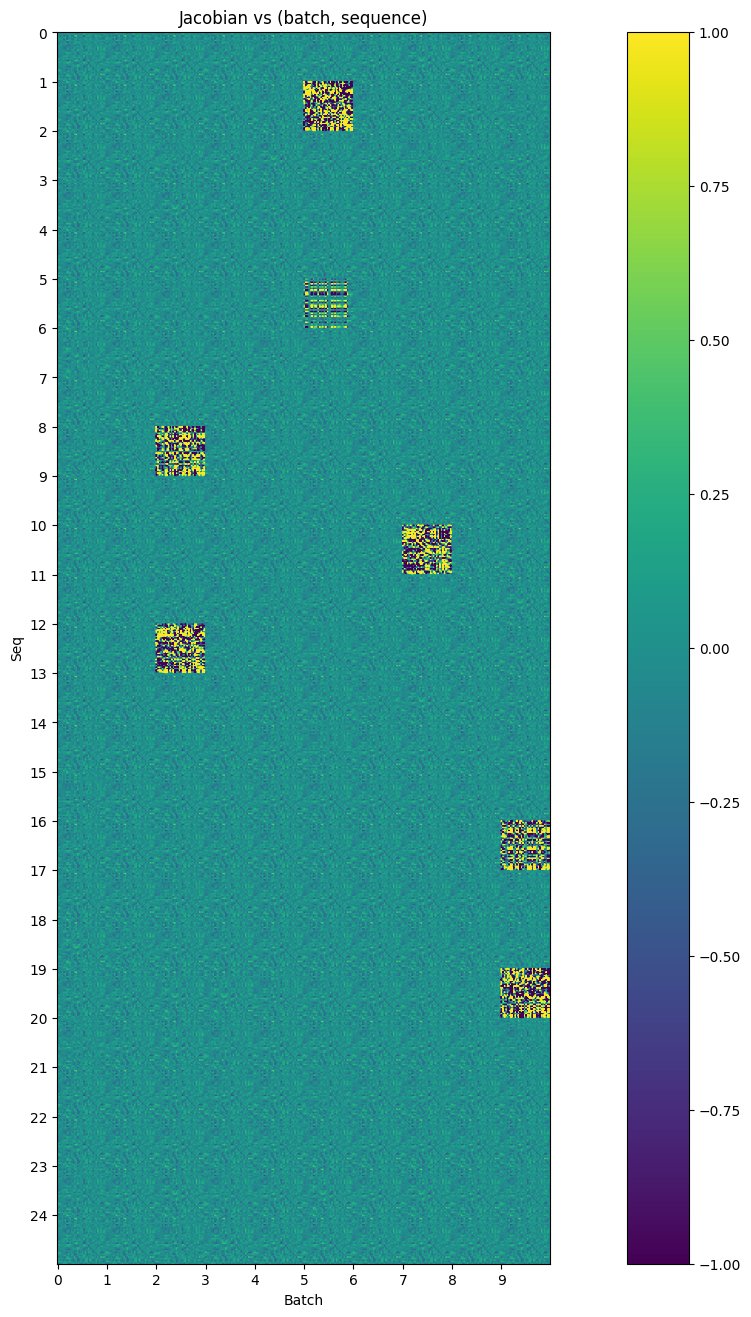

In [23]:
fig, ax = plt.subplots(figsize=(20, 16))
num_seq = 25
num_batch = 10
f = ax.imshow(einops.rearrange(jacobian[:num_batch, :num_seq], "batch seq d_res1 d_res2 -> (seq d_res1) (batch d_res2)").cpu(), vmin=-1, vmax=1)
plt.colorbar(f)
plt.title("Jacobian vs (batch, sequence)")
plt.xlabel("Batch")
plt.ylabel("Seq")
plt.xticks(ticks=np.arange(num_batch)*jacobian.shape[-1], labels=np.arange(num_batch))
plt.yticks(ticks=np.arange(num_seq)*jacobian.shape[-2], labels=np.arange(num_seq))
plt.show()

## Observations about the Jacobian
Looking at the plot, there are some interesting observations:

- The MLP definitely appears to have a default behavior. Different tiles (with a few clear exceptions) look remarkably similar to one another
- There are a few cases where the MLP behaves extremely differently. This turns out to be (generally) in cases where a trigram is present. These jacobians are orders of magnitude larger than the typical jacobians.

Looking more closely at a single "default" jacobian (in this case, batch=0, seq=0), we can actually make out some features:

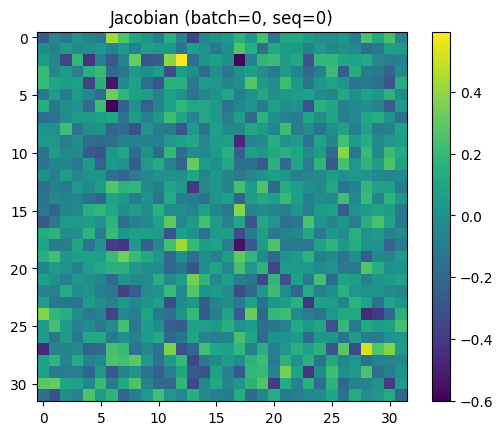

In [24]:
plt.figure()
f = plt.imshow(jacobian[0, 0].cpu())
plt.title("Jacobian (batch=0, seq=0)")
plt.colorbar(f)
plt.show()

1. The MLP slightly erases a number of leading-diagonal terms. Given this, we should probably expect direct logit attribution of upstream vectors to perform worse than on a model trained without this MLP.
2. The MLP isn't just erasing data, it's *moving* data. There are some clear hotspots ((12, 2) in the jacobian, for example) that repeat amongst different sequence positions.

It's also important to remember that once we fix a jacobian (i.e. we *linearize the MLP*), the jacobian can no longer add extra information to the residual stream, and instead only moves it around.

What's an appropriate jacobian to fix? We could try the mean:

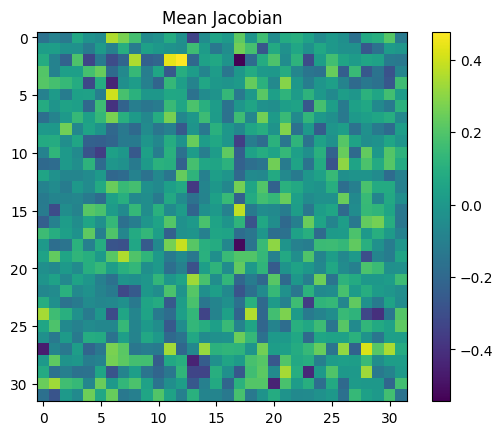

In [25]:
jac_mean = jacobian.mean(dim=[0, 1])
plt.figure()
plt.title("Mean Jacobian")
f = plt.imshow(jac_mean.cpu())
plt.colorbar(f)

However, this is not an especially principled choice - when the MLP does activate, the jacobian is changed dramatically. Taking the mean includes the influence of these very large activations, even if we don't really want to.

Instead, we can try the median:

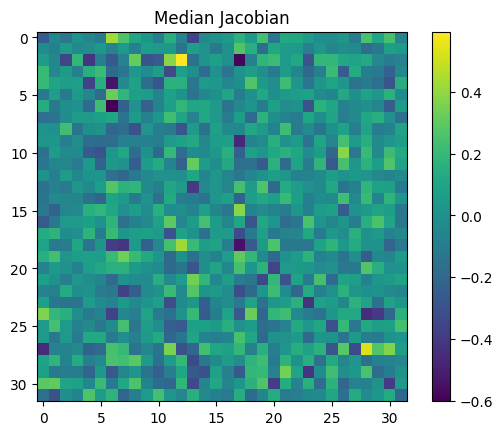

In [26]:
jac_median = jacobian.median(dim=0).values.median(dim=0).values
plt.figure()
plt.title("Median Jacobian")
f = plt.imshow(jac_median.cpu())
plt.colorbar(f)

This looks a lot more like our `jacobian[0, 0]` (and other unactivated MLP jacobians)!

So, now that we have $J$, we just need to calculate our bias, $b$, since the MLP ignores constants. To do so, we rearrange the definition of the jacobian:

$$
\begin{align}
y &= J x + b \\
b &= y - J x \\
  & = x_\text{post} - J x_\text{mid} \\
\end{align}
$$

Using similar justification to before, we pick the median bias:

In [27]:
projected = einops.einsum(jacobian, cache['blocks.0.hook_resid_mid'],
                          "... seq d_model_out d_model_in, ... seq d_model_in -> ... seq d_model_out")
bias = (cache['blocks.0.hook_mlp_out'] - projected).median(dim=0).values.median(dim=0).values

# Testing the Linearization

So, now that we've frozen the MLP in linearized form, do we get better predictions from the attention mechanism?

In [28]:
def attention_predict(trigram):
    _, c = model.run_with_cache(t.tensor([[trigram[0], trigram[1]]], device=device),
                                names_filter=["blocks.0.hook_resid_mid"])
    resid_after_attn = c['blocks.0.hook_resid_mid']
    resid_post_approx = bias + resid_after_attn + einops.einsum(jac_median, resid_after_attn,
                          "d_model_out d_model_in, ... seq d_model_in -> ... seq d_model_out")

    return model.unembed(resid_post_approx)[0, -1].argmax(dim=-1).cpu().item()

correct = 0

for trigram in dataset.trigrams:
    prediction = attention_predict(trigram)
    if prediction == trigram[2]:
        correct += 1

print(f"Accuracy = {correct / len(dataset.trigrams)}")

Accuracy = 0.3104693140794224


Yes!!

By better accounting for the passive behaviour of the MLP, we go from ~25% accuracy to ~31% accuracy using only the attention mechanism's logic (since jac_median and bias are just frozen, linear transformations.)

In relative terms, we discovered ~25% more performance from the attention mechanism. It's still a long way from explaining the entirety of the model's performance, but it's a step.

# How the model predicts the rest of the tokens

Given what we know about the rest of the model, we can hypothesize the following about the MLP:
1. It reads from the stream written to by the OV circuit, as well as the current token stream.
2. It uses the results from these two streams to retrieve the correct completion. From this, it writes into the unembedding direction corresponding to this conclusion to boost the logits, and potentially even supresses other likely completions.

An attempt to analyse the MLP using a sparse transcoder was used. In this case, a transcoder seemed like it could work well because we have clearly defined inputs (e.g. 16 in position 0, 43 in position 1 -> predicts 68).

However, although a number of different attempts were made (varying transcoder widths, warm-up vs cold-start for learning rate and l1 penalty, varieties of learning rates, batch sizes, resampling frequencies etc.), no transcoders emerged that provided cleanly interpretable features.

It seems likely that good results could come from pursuing this further, but the results obtained in attempts thus far are uninteresting.

## One last trick
One trick we have left is to look at what subspaces the MLP reads in. The MLP has dimension 20, the model (residual stream) has dimension 32, and the attention head has dimension 16. This means that the MLP could fully read from the output space of the attention head, but cannot read the full token stream.

We can observe how it weights these two competing priorities based on the distance between subspaces. This isn't guaranteed to be meaningful for reasons I [wrote about here](https://www.willsnell.com/posts/math_composition/), but might still give us some idea.

In [29]:
from dataclasses import dataclass

@dataclass
class SubspaceMetrics:
  theta: Float[Tensor, "d_hidden"]
  cos_theta: Float[Tensor, "d_hidden"]
  principal_vecs_out: Float[Tensor, "d_model d_hidden"]
  principal_vecs_in: Float[Tensor, "d_model d_hidden"]
  U: Float[Tensor, "d_head d_head"]
  Vh: Float[Tensor, "d_head d_head"]



def qr_svd(out_mat: Float[Tensor, "d_hidden d_model"],
           in_mat: Float[Tensor, "d_model d_hidden"]
           ) -> SubspaceMetrics:
    """Purpose:
           Calculate statistics between the two subspaces
           spanned by the matrices `out_mat` and `in_mat`,
           These matrices should write to/read from a
           common space of dimension `d_model`.

           Calculate the principal vectors of the subspaces
           spanned by out_mat and in_mat.

           Also return the angle between each set of principal
           vectors (aka the principal angles, theta).
           theta[0] <= ... <= theta[-1]

       Returns:
           (theta, cos(theta), principal_vectors_out_mat,
            principal_vectors_in_mat, U, Vh)

       Follows the procedure in
       https://helper.ipam.ucla.edu/publications/glws1/glws1_15465.pdf

       Assumptions:
           Assumes the first n columns in a
           m x n (m >= n) matrix are linearly
           independent.

           E.g. in W_O.T, shape [768, 64],
           the first 64 columns should be
           linearly independent.
    """
    # Q is the set of orthonormal basis vectors
    # for the subspace spanned by each matrix.

    q_out, r_out = t.linalg.qr(out_mat.transpose(-1, -2))
    q_in, r_in = t.linalg.qr(in_mat)

    # Compute the deviation between the
    # two subspaces using SVD.

    U, S, Vh = t.linalg.svd(q_out.transpose(-1, -2) @ q_in)

    # Principal vectors let us know what directions were
    # chosen to calculate theta. That is, each are a set
    # of basis vectors that span the spaces of the
    # respective matrices (in or out) and are most closely
    # aligned to each other.
    principal_vectors_out_mat = q_out @ U
    principal_vectors_in_mat = q_in @ Vh.transpose(-1, -2)

    theta = t.arccos(S)

    return SubspaceMetrics(
        t.arccos(S),
          S,
          principal_vectors_out_mat,
          principal_vectors_in_mat,
          U,
          Vh
    )

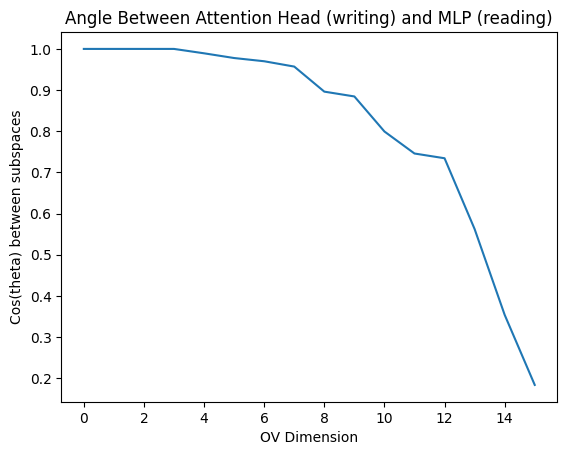

cos(theta) = [1.0000001192092896, 1.0, 0.9999998807907104, 0.9999998807907104, 0.9893388152122498, 0.9778618216514587, 0.9700286984443665, 0.9570831656455994, 0.8961935639381409, 0.8844886422157288, 0.7993403673171997, 0.745817244052887, 0.7342832088470459, 0.5622190237045288, 0.35370132327079773, 0.18341064453125]


In [30]:
res = qr_svd(model.W_O[0, 0], model.blocks[0].mlp.W_in)
plt.plot(res.cos_theta.detach().cpu())
plt.title("Angle Between Attention Head (writing) and MLP (reading)")
plt.xlabel("OV Dimension")
plt.ylabel("Cos(theta) between subspaces")
plt.show()
print(f"cos(theta) = {res.cos_theta.tolist()}")

So, the MLP pays very close attention to the first 4 dimensions output by the OV circuit, and then pays increasingly less attention. There's a sharp dropoff around the 9th dimension, which implies the MLP's focus is (very crudely) around 50% on the OV circuit and 50% on the current stream, assuming the residual stream has similar variance in all directions.

To verify this assumption, we can look at the residual stream directly:

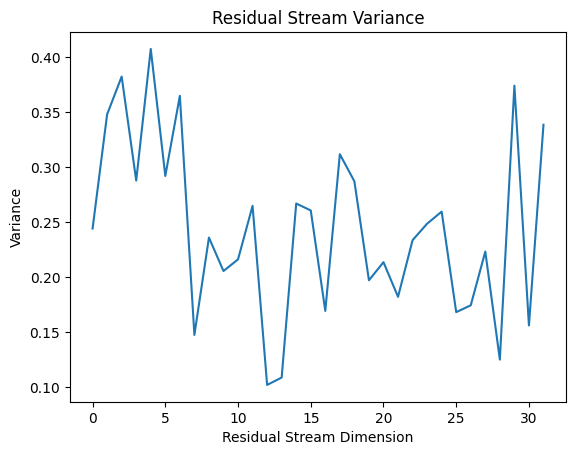

In [31]:
var_resid_mid = cache['blocks.0.hook_resid_mid'].var(dim=[0, 1])
plt.plot(var_resid_mid)
plt.title("Residual Stream Variance")
plt.xlabel("Residual Stream Dimension")
plt.ylabel("Variance")
plt.show()

So, while the residual stream is not equal in magnitude for all directions, everything is within an order of magnitude. For this very crude subspace measurement, it's probably close enough to uniform that we can use subspace angles to quantify how much focus the MLP is placing in different subspaces.